In [17]:
import json
from pathlib import Path
from tqdm.notebook import tqdm
import typing as tp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

In [2]:
def rle2mask(mask_rle: str, shape: tp.Tuple[int, int]) -> np.ndarray:
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [3]:
data_path = Path('/anvar/public_datasets/hubmap/')

In [4]:
train_df = pd.read_csv(data_path / 'train.csv')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [5]:
test_df = pd.read_csv(data_path / 'test.csv')
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


In [6]:
(train_df.id == 10078).sum()

0

In [7]:
len(train_df), len(train_df.id.unique())

(351, 351)

In [11]:
organs = sorted(train_df.organ.unique())
organs

['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']

In [18]:
image_id = 10044
image = tifffile.imread(data_path / 'train_images' / f'{image_id}.tiff')
masks = {}
for organ in organs:
    row = train_df[(train_df.id == image_id) & (train_df.organ == organ)]
    if len(row) == 0:
        continue
    masks[organ] = rle2mask(row.iloc[0].rle, image.shape[:2])

In [19]:
masks.keys()

dict_keys(['prostate'])

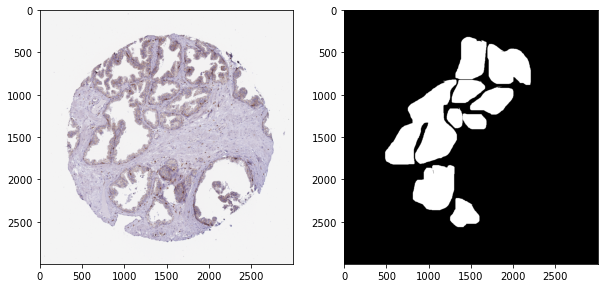

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[1].imshow(masks['prostate'], cmap='gray')

In [25]:
temp_masks_path = Path('/home/liza/temp/data/hubmap/train_masks')

for i, row in train_df.iterrows():
    image = tifffile.imread(data_path / 'train_images' / f'{image_id}.tiff')
    image_id = row.id
    mask = rle2mask(row.rle, image.shape[:2])
    np.savez_compressed(temp_masks_path / f'{image_id}.npz', mask,)